<a href="https://colab.research.google.com/github/uveysturhan/condensed-matter-related/blob/main/Kapit_Mueller_Bose_Hubbard_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install quspin
import quspin
from quspin.basis.basis_general import boson_basis_general
from quspin.operators import hamiltonian
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from IPython.display import Latex, display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.9/199.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.0/282.0 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.6 MB/s eta 0:00:00


In [2]:
import numpy as np
from quspin.basis.basis_general import boson_basis_general
from quspin.operators import hamiltonian

#define the hopping amplitude parameters, given in eqn(2).
#dx is the difference of the x-coordinates, i.e dx = x_i - x_j, for 0<=i,j<L.
def W_z(dx, dy, phi, t=1.0):
    G_z = (-1)**(dx + dy + dx*dy)
    return t * G_z * np.exp(- (np.pi/2)*(1-phi)*(dx*dx + dy*dy))

def km_bose_hubbard(Lx, Ly, N_total, n_max,
                                phi, U=1.0, t=0.5):
    L   = Lx*Ly
    sps = n_max + 1

    # construct bosonic basis
    basis = boson_basis_general(L, Nb=N_total, sps=sps)
    print("Hilbert‐space dimension:", basis.Ns)

    # compute J_L [eq(10) in the paper] to construct the hopping list
    hop_pm, hop_mp = [], []
    for j in range(L):
        xj, yj = divmod(j, Ly) # j = xj*Ly + yj, xj is the quotient and yj is the remainder.
        zj_c   = xj + 1j*yj

        for k in range(L):
            if k == j:
              continue
            xk, yk = divmod(k, Ly)

            # sum over n, m, where R = n*Lx + i*m*Ly
            J_L = 0+0j
            for n in (-1,0,1):
                for m in (-1,0,1):
                    dx = xk - xj + n*Lx
                    dy = yk - yj + m*Ly

                    # find J in eq(1)
                    phase = np.exp(1j * np.pi * (xk*yj - yk*xj)*phi)

                    # add magneto‐periodic phase [eq(10)]
                    R = n*Lx + 1j*m*Ly
                    mp = np.exp((np.pi/2)*(zj_c*np.conj(R)
                                                - np.conj(zj_c)*R)*phi)

                    #sum over R
                    J_L += W_z(dx, dy, phi, t) * phase * mp

            #construct the hopping list and its h.c
            hop_pm.append([J_L, j, k])
            hop_mp.append([np.conj(J_L), k, j])

    # interaction term: U/2 n(n−1) = U/2  n^2 − U/2 n
    nn = [[U/2, i, i] for i in range(L)]
    n1 = [[-U/2, i]   for i in range(L)]

    static = [
        ["+-", hop_pm],
        ["+-", hop_mp],
        ["nn", nn],
        ["n",  n1]
    ]
    dynamic = []

    #construct and diagonalize the hamiltonian
    H = hamiltonian(static, dynamic,
                    basis=basis,
                    dtype=np.complex128)

    #now we construct creation, annihilation and number operators
    a = {}
    adag = {}
    num = {}
    for j in range(L):
      a[j] = hamiltonian(
        [["-", [[1.0, j]]]],
        [],
        basis=basis,
        dtype=np.complex128,
        check_herm=False,
        check_pcon=False,
        check_symm=False)

      adag[j] = hamiltonian(
          [["+", [[1.0, j]]]],
          [],
          basis=basis,
          dtype=np.complex128,
        check_herm=False,
        check_pcon=False,
        check_symm=False
        )
      num[j] = hamiltonian(
          [["n", [[1.0, j]]]],
          [],
          basis=basis,
          dtype=np.complex128,
        check_herm=False,
        check_pcon=False,
        check_symm=False)

    eigvals, eigvecs = H.eigh()
    return eigvals, eigvecs, H, hop_pm, hop_mp, nn, n1, a, adag, num, Lx, Ly, N_total, n_max, U, t, phi

Hilbert‐space dimension: 1820
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


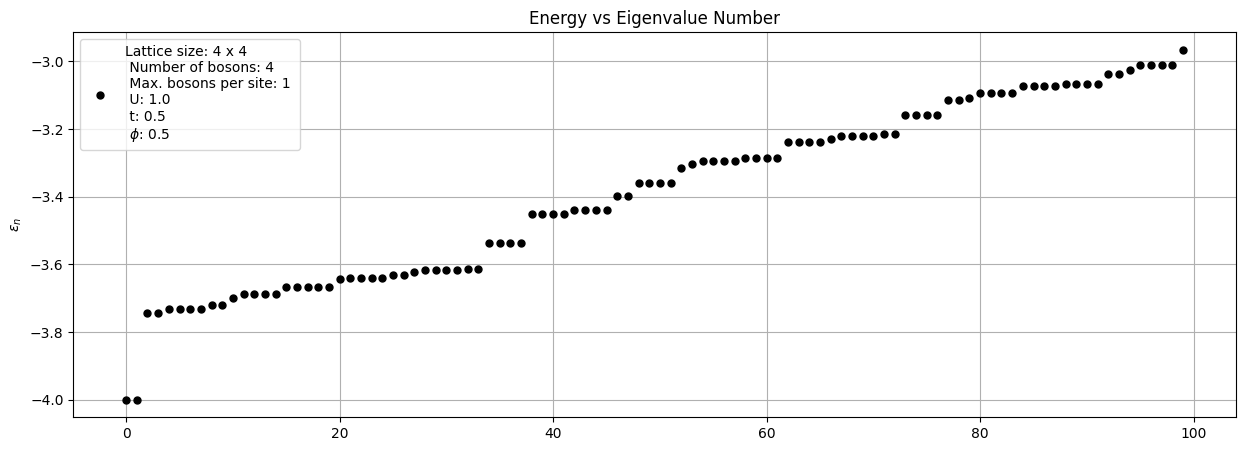

In [3]:
#many body spectrum, Fig.2 in the paper
eigvals, eigvecs, H, hop_pm, hop_mp, nn, n1, a, adag, num, Lx, Ly, N_total, n_max, U, t, phi = km_bose_hubbard(
        Lx=4, Ly=4,
        N_total=4, n_max=1,
        phi=1/2, U=1.0, t=0.5)
plt.figure(figsize=(15, 5))
plt.plot(eigvals[:100], mec="k", mfc= "k", marker='o', markersize=5, label=f'Lattice size: {Lx} x {Ly} \n Number of bosons: {N_total} \n Max. bosons per site: {n_max} \n U: {U} \n t: {t} \n $\phi$: {phi}', linestyle='none')
plt.ylabel('$\epsilon_n$')
plt.title('Energy vs Eigenvalue Number')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
#many body spectrum
for n, e in enumerate(eigvals[:100]):
  print(f"{n:3d}  {e:.6f}")

  0  -4.000056
  1  -4.000056
  2  -3.742939
  3  -3.742939
  4  -3.730618
  5  -3.730618
  6  -3.730618
  7  -3.730618
  8  -3.719249
  9  -3.718980
 10  -3.699632
 11  -3.688035
 12  -3.688035
 13  -3.688035
 14  -3.688035
 15  -3.667454
 16  -3.666872
 17  -3.666872
 18  -3.666872
 19  -3.666872
 20  -3.642433
 21  -3.641198
 22  -3.641198
 23  -3.641198
 24  -3.641198
 25  -3.631098
 26  -3.631098
 27  -3.621524
 28  -3.615487
 29  -3.615487
 30  -3.615487
 31  -3.615487
 32  -3.614704
 33  -3.614704
 34  -3.535720
 35  -3.535720
 36  -3.535720
 37  -3.535720
 38  -3.450406
 39  -3.450406
 40  -3.450406
 41  -3.450406
 42  -3.440777
 43  -3.440777
 44  -3.440777
 45  -3.440777
 46  -3.396486
 47  -3.396486
 48  -3.358951
 49  -3.358951
 50  -3.358951
 51  -3.358951
 52  -3.315983
 53  -3.303744
 54  -3.293367
 55  -3.293367
 56  -3.293367
 57  -3.293367
 58  -3.285924
 59  -3.285924
 60  -3.285924
 61  -3.285924
 62  -3.239157
 63  -3.239157
 64  -3.239157
 65  -3.239157
 66  -3.22

In [5]:
#creation, annihilation, number and hamiltonian operators in matrix form
adag0_mat = adag[0].toarray()
print(f"Creation operator, dimension: {adag0_mat.shape}", adag0_mat, sep="\n")
a0_mat = a[0].toarray()
print(f"Annihilation operator,dimension: {a0_mat.shape}", a0_mat, sep="\n")
n_mat = num[0].toarray()
print(f"Number operator, dimension: {n_mat.shape}", n_mat, sep="\n")
H_mat = H.toarray()
print(f"Hamiltonian, dimension: {H_mat.shape}", H_mat, sep="\n")


Creation operator, dimension: (1820, 1820)
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
Annihilation operator,dimension: (1820, 1820)
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
Number operator, dimension: (1820, 1820)
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0

Hilbert‐space dimension: 144
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


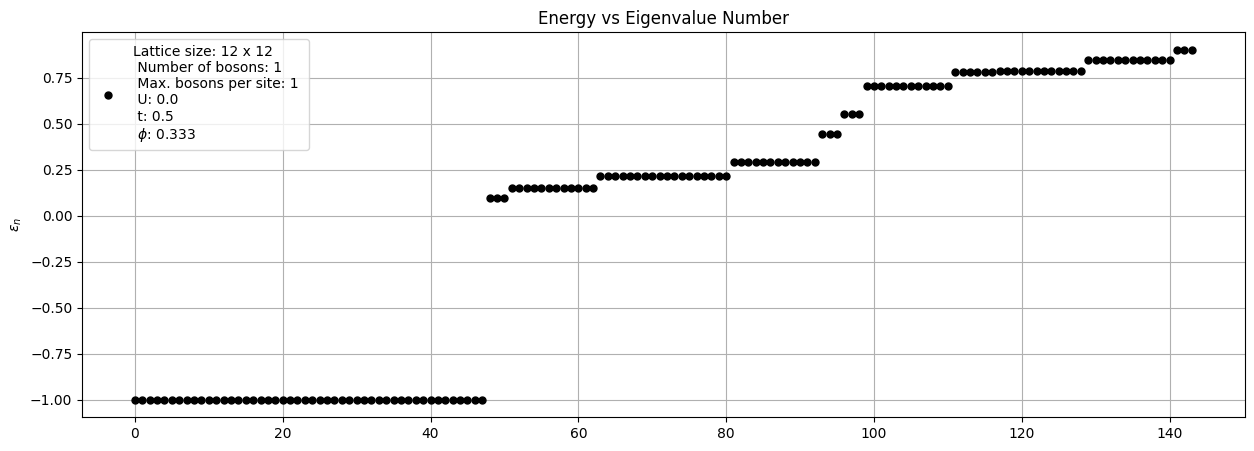

In [10]:
#Single particle spectrum, Fig.1 in the paper.
eigvals, eigvecs, H, hop_pm, hop_mp, nn, n1, a, adag, num, Lx, Ly, N_total, n_max, U, t, phi = km_bose_hubbard(
        Lx=12, Ly=12,
        N_total=1, n_max=1,
        phi=1/3, U=0.0, t=0.5)
plt.figure(figsize=(15, 5))
plt.plot(eigvals[:], mec="k", mfc= "k", marker='o', markersize=5, label=f'Lattice size: {Lx} x {Ly} \n Number of bosons: {N_total} \n Max. bosons per site: {n_max} \n U: {U} \n t: {t} \n $\phi$: {np.round(phi, 3)}', linestyle='none')
plt.ylabel('$\epsilon_n$')
plt.title('Energy vs Eigenvalue Number')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
#single particle spectrum
for n, e in enumerate(eigvals[:]):
  print(f"{n:3d}  {e:.6f}")

  0  -1.000000
  1  -1.000000
  2  -1.000000
  3  -1.000000
  4  -1.000000
  5  -1.000000
  6  -1.000000
  7  -1.000000
  8  -1.000000
  9  -1.000000
 10  -1.000000
 11  -1.000000
 12  -1.000000
 13  -1.000000
 14  -1.000000
 15  -1.000000
 16  -1.000000
 17  -1.000000
 18  -1.000000
 19  -1.000000
 20  -1.000000
 21  -1.000000
 22  -1.000000
 23  -1.000000
 24  -1.000000
 25  -1.000000
 26  -1.000000
 27  -1.000000
 28  -1.000000
 29  -1.000000
 30  -1.000000
 31  -1.000000
 32  -1.000000
 33  -1.000000
 34  -1.000000
 35  -1.000000
 36  -1.000000
 37  -1.000000
 38  -1.000000
 39  -1.000000
 40  -1.000000
 41  -1.000000
 42  -1.000000
 43  -1.000000
 44  -1.000000
 45  -1.000000
 46  -1.000000
 47  -1.000000
 48  0.098431
 49  0.098431
 50  0.098431
 51  0.152016
 52  0.152016
 53  0.152016
 54  0.152016
 55  0.152016
 56  0.152016
 57  0.152016
 58  0.152016
 59  0.152016
 60  0.152016
 61  0.152016
 62  0.152016
 63  0.214385
 64  0.214385
 65  0.214385
 66  0.214385
 67  0.214385
